# Grid Search Results Heatmap

This notebook creates heatmap visualizations of the grid search results to help identify optimal parameter combinations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visualization style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
# Load the grid search results
results_file = 'full_grid_search_results4.csv'
df = pd.read_csv(results_file)

# Display the first few rows to understand the data structure
print(f"Total parameter combinations tested: {len(df)}")
df.head()

Total parameter combinations tested: 135


,entry_threshold,exit_threshold,entry_price_adjustment,exit_price_adjustment,2--1,2-0,total_profit
0,5.75,1.75,5.0,1.0,59759,45471,105230
1,5.50,1.75,5.0,1.0,60722,44110,104832
2,5.50,1.25,5.0,1.0,60785,44037,104822
3,5.75,1.50,5.0,1.0,59359,45213,104572
4,5.50,1.50,5.0,1.0,60566,43854,104420


In [3]:
# Check the unique values for each parameter
for col in ['entry_threshold', 'exit_threshold', 'entry_price_adjustment', 'exit_price_adjustment']:
    print(f"{col}: {sorted(df[col].unique())}")

entry_threshold: [5.5, 5.75, 6.0]
exit_threshold: [1.25, 1.5, 1.75]
entry_price_adjustment: [3.0, 4.0, 5.0, 6.0, 7.0]
exit_price_adjustment: [1.0, 2.0, 3.0]


## 2D Heatmaps for Parameter Pairs

Let's create heatmaps for different pairs of parameters to visualize their impact on total profit.

In [4]:
# Function to create a 2D heatmap for a pair of parameters
def create_2d_heatmap(df, param1, param2, fixed_params=None):
    # Filter data if fixed parameters are provided
    if fixed_params:
        filtered_df = df.copy()
        for param, value in fixed_params.items():
            filtered_df = filtered_df[filtered_df[param] == value]
    else:
        filtered_df = df
    
    # Create a pivot table
    pivot_df = filtered_df.pivot_table(
        values='total_profit', 
        index=param1, 
        columns=param2,
        aggfunc='mean'  # Use mean in case there are multiple entries
    )
    
    # Create the heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(pivot_df, annot=True, fmt=",.0f", cmap="YlGnBu", linewidths=0.5)
    
    # Set title and labels
    title = f"Total Profit by {param1} and {param2}"
    if fixed_params:
        fixed_params_str = ", ".join([f"{p}={v}" for p, v in fixed_params.items()])
        title += f" (Fixed: {fixed_params_str})"
    plt.title(title)
    plt.ylabel(param1)
    plt.xlabel(param2)
    
    # Find the maximum value and highlight it
    max_idx = pivot_df.stack().idxmax()
    max_value = pivot_df.stack().max()
    print(f"Maximum profit {max_value:.0f} at {param1}={max_idx[0]}, {param2}={max_idx[1]}")
    
    plt.tight_layout()
    return pivot_df

Maximum profit 90697 at entry_threshold=5.5, exit_threshold=1.25


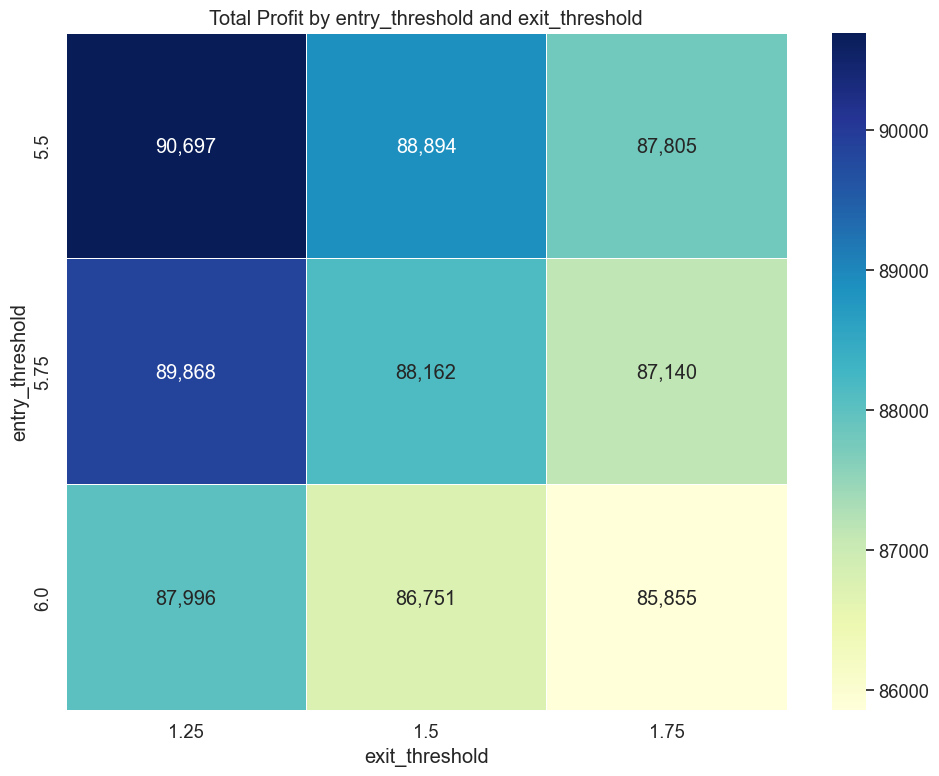

In [5]:
# Create heatmap for entry_threshold vs exit_threshold
# Average across all entry_price_adjustment and exit_price_adjustment values
pivot_entry_exit = create_2d_heatmap(df, 'entry_threshold', 'exit_threshold')

Maximum profit 102230 at entry_price_adjustment=6.0, exit_price_adjustment=1.0


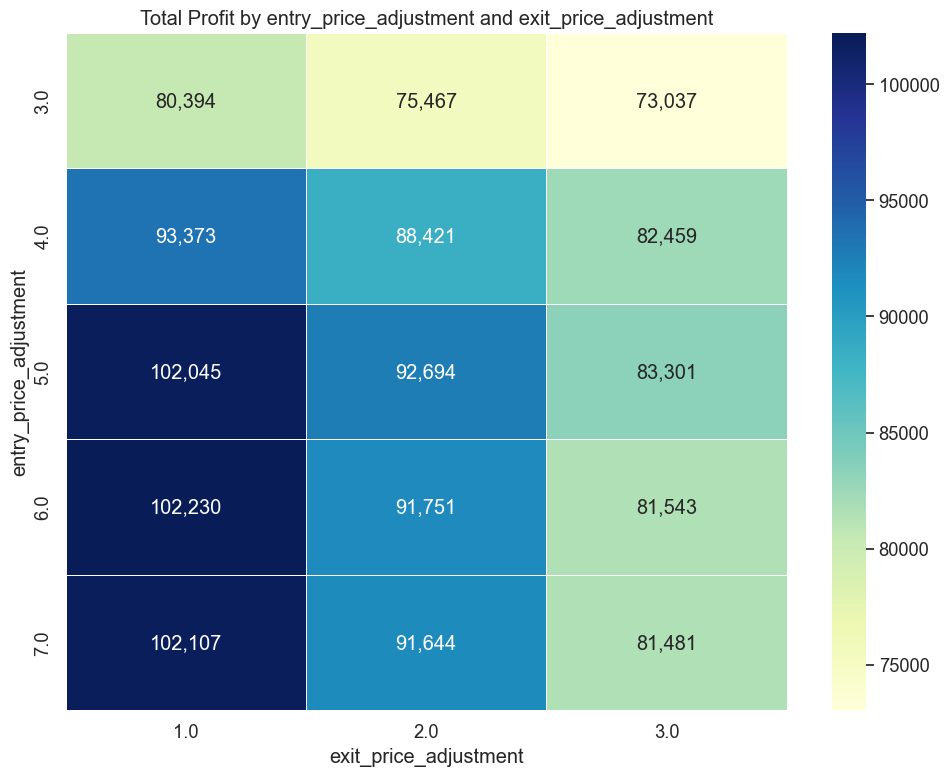

In [6]:
# Create heatmap for entry_price_adjustment vs exit_price_adjustment
# Average across all entry_threshold and exit_threshold values
pivot_entry_exit_price = create_2d_heatmap(df, 'entry_price_adjustment', 'exit_price_adjustment')

## Conditional Heatmaps

Now let's create heatmaps with fixed values for some parameters to see more detailed relationships.

Best entry_threshold: 5.75
Best exit_threshold: 1.75
Maximum profit 105230 at entry_price_adjustment=5.0, exit_price_adjustment=1.0


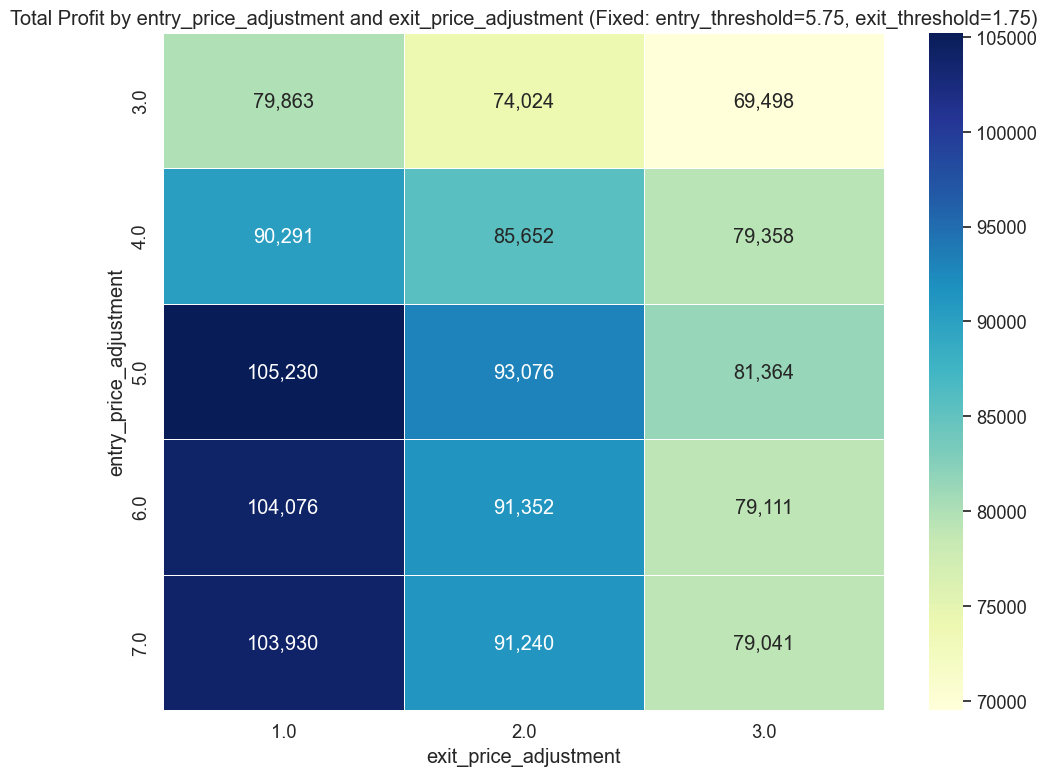

In [7]:
# Find the best entry_threshold and exit_threshold
best_entry = df.loc[df['total_profit'].idxmax(), 'entry_threshold']
best_exit = df.loc[df['total_profit'].idxmax(), 'exit_threshold']

print(f"Best entry_threshold: {best_entry}")
print(f"Best exit_threshold: {best_exit}")

# Create heatmap for entry_price_adjustment vs exit_price_adjustment with fixed best thresholds
pivot_price_adj = create_2d_heatmap(
    df, 
    'entry_price_adjustment', 
    'exit_price_adjustment',
    fixed_params={'entry_threshold': best_entry, 'exit_threshold': best_exit}
)

Best entry_price_adjustment: 5.0
Best exit_price_adjustment: 1.0
Maximum profit 105230 at entry_threshold=5.75, exit_threshold=1.75


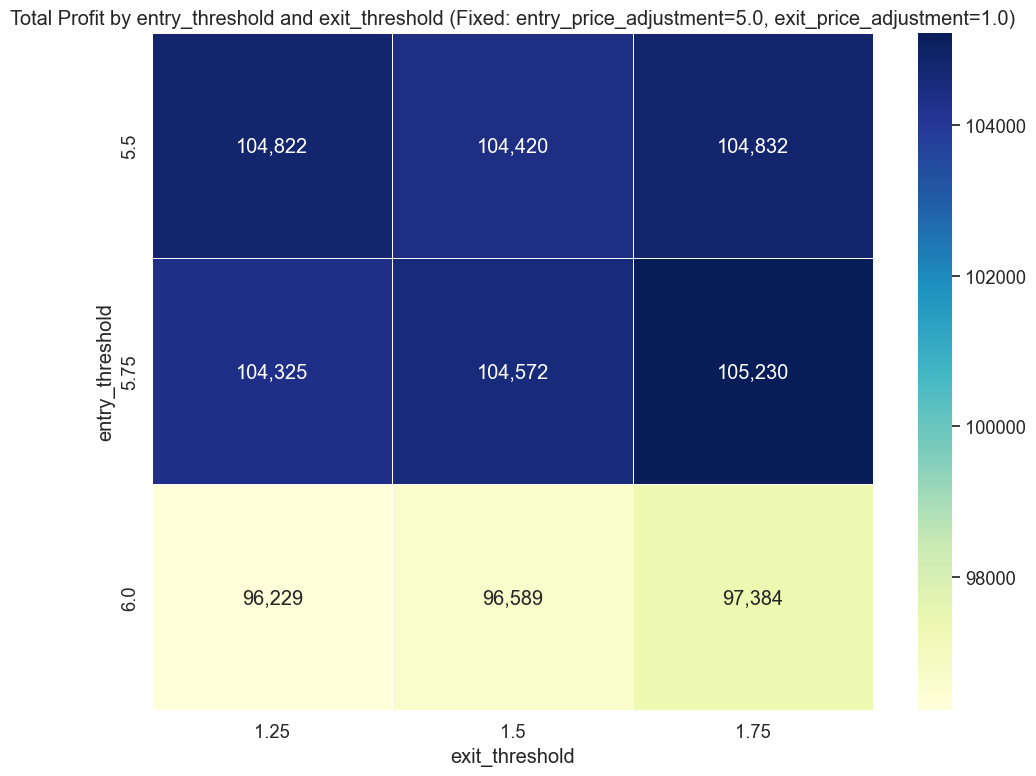

In [8]:
# Find the best entry_price_adjustment and exit_price_adjustment
best_entry_price = df.loc[df['total_profit'].idxmax(), 'entry_price_adjustment']
best_exit_price = df.loc[df['total_profit'].idxmax(), 'exit_price_adjustment']

print(f"Best entry_price_adjustment: {best_entry_price}")
print(f"Best exit_price_adjustment: {best_exit_price}")

# Create heatmap for entry_threshold vs exit_threshold with fixed best price adjustments
pivot_thresholds = create_2d_heatmap(
    df, 
    'entry_threshold', 
    'exit_threshold',
    fixed_params={'entry_price_adjustment': best_entry_price, 'exit_price_adjustment': best_exit_price}
)

## Profit by Day Analysis

Let's analyze how the parameters affect profit on each day separately.

In [9]:
# Get the day columns (excluding parameter and total_profit columns)
day_columns = [col for col in df.columns if col not in ['entry_threshold', 'exit_threshold', 
                                                        'entry_price_adjustment', 'exit_price_adjustment', 
                                                        'total_profit']]

print(f"Days in the dataset: {day_columns}")

Days in the dataset: ['2--1', '2-0']


Maximum profit 56269 at entry_threshold=5.5, exit_threshold=1.25
Maximum profit 34532 at entry_threshold=5.75, exit_threshold=1.25


<Figure size 1000x800 with 0 Axes>

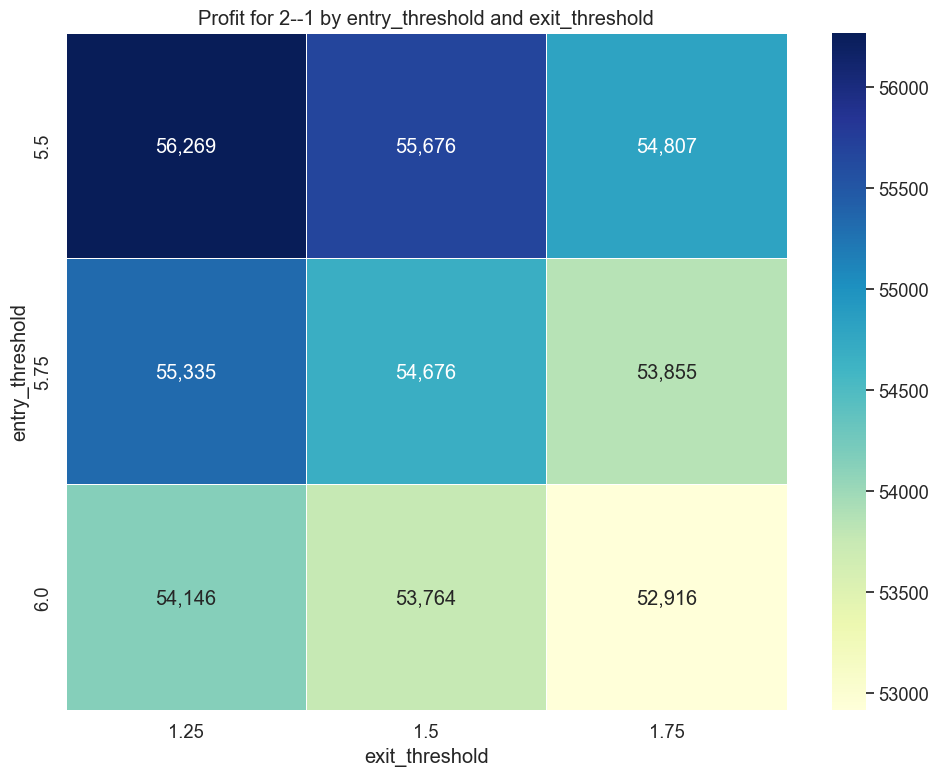

<Figure size 1000x800 with 0 Axes>

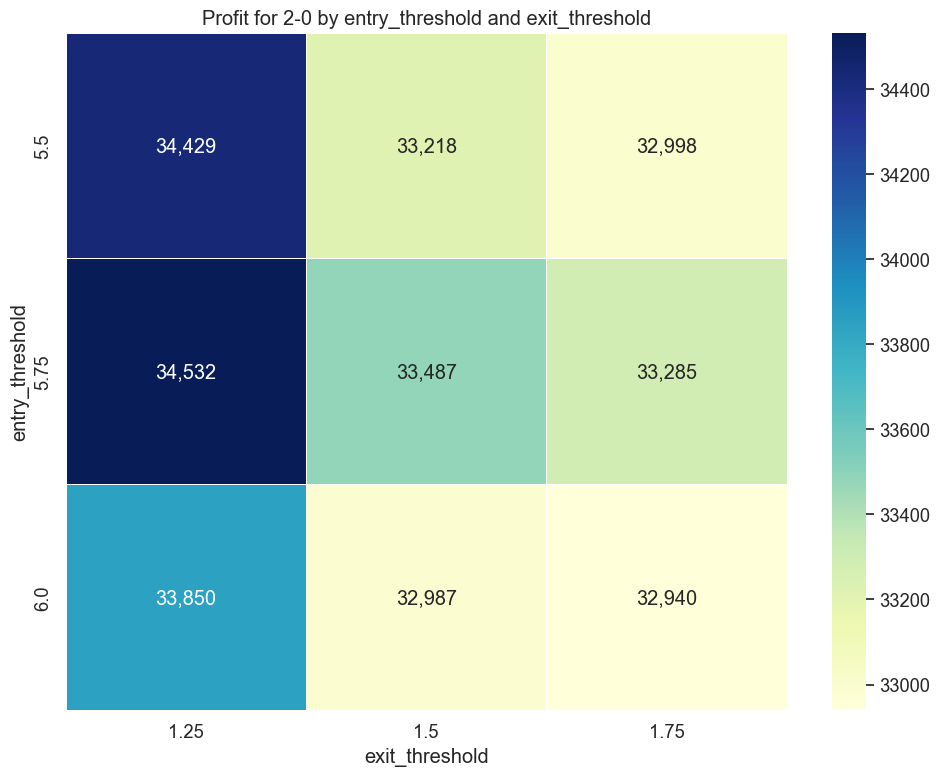

In [10]:
# Create heatmaps for each day
for day in day_columns:
    plt.figure(figsize=(10, 8))
    
    # Create a temporary dataframe with the day's profit as total_profit
    temp_df = df.copy()
    temp_df['total_profit'] = temp_df[day]
    
    # Create heatmap for entry_threshold vs exit_threshold for this day
    pivot_day = create_2d_heatmap(temp_df, 'entry_threshold', 'exit_threshold')
    plt.title(f"Profit for {day} by entry_threshold and exit_threshold")

## 3D Visualization

Let's create a 3D surface plot to visualize the relationship between three parameters.

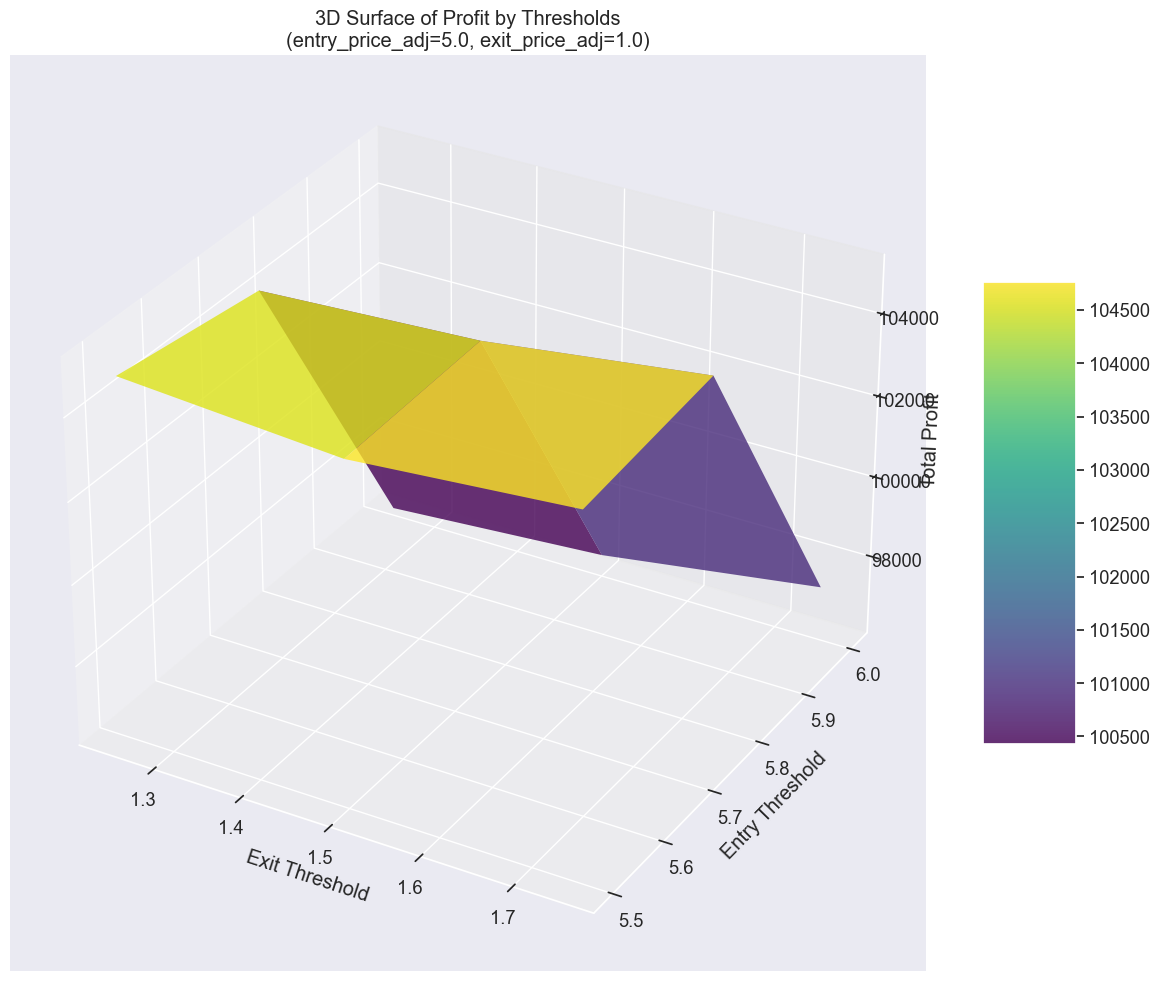

In [11]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D surface plot for entry_threshold, exit_threshold, and total_profit
# with fixed price adjustments
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Filter data for the best price adjustments
filtered_df = df[
    (df['entry_price_adjustment'] == best_entry_price) & 
    (df['exit_price_adjustment'] == best_exit_price)
]

# Create the 3D surface
pivot = filtered_df.pivot_table(
    values='total_profit', 
    index='entry_threshold', 
    columns='exit_threshold'
)

# Get the X, Y, Z data
X, Y = np.meshgrid(pivot.columns, pivot.index)
Z = pivot.values

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Add labels and title
ax.set_xlabel('Exit Threshold')
ax.set_ylabel('Entry Threshold')
ax.set_zlabel('Total Profit')
ax.set_title(f'3D Surface of Profit by Thresholds\n(entry_price_adj={best_entry_price}, exit_price_adj={best_exit_price})')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

## Best Parameter Combinations

Let's identify the top parameter combinations.

In [12]:
# Display the top 10 parameter combinations
top_10 = df.sort_values('total_profit', ascending=False).head(10)
top_10

,entry_threshold,exit_threshold,entry_price_adjustment,exit_price_adjustment,2--1,2-0,total_profit
0,5.75,1.75,5.0,1.0,59759,45471,105230
1,5.50,1.75,5.0,1.0,60722,44110,104832
2,5.50,1.25,5.0,1.0,60785,44037,104822
3,5.75,1.50,5.0,1.0,59359,45213,104572
4,5.50,1.50,5.0,1.0,60566,43854,104420
5,5.75,1.25,5.0,1.0,59182,45143,104325
6,5.75,1.75,6.0,1.0,59216,44860,104076
7,5.50,1.75,6.0,1.0,61212,42766,103978
8,5.50,1.25,6.0,1.0,61233,42740,103973
9,5.75,1.75,7.0,1.0,59079,44851,103930


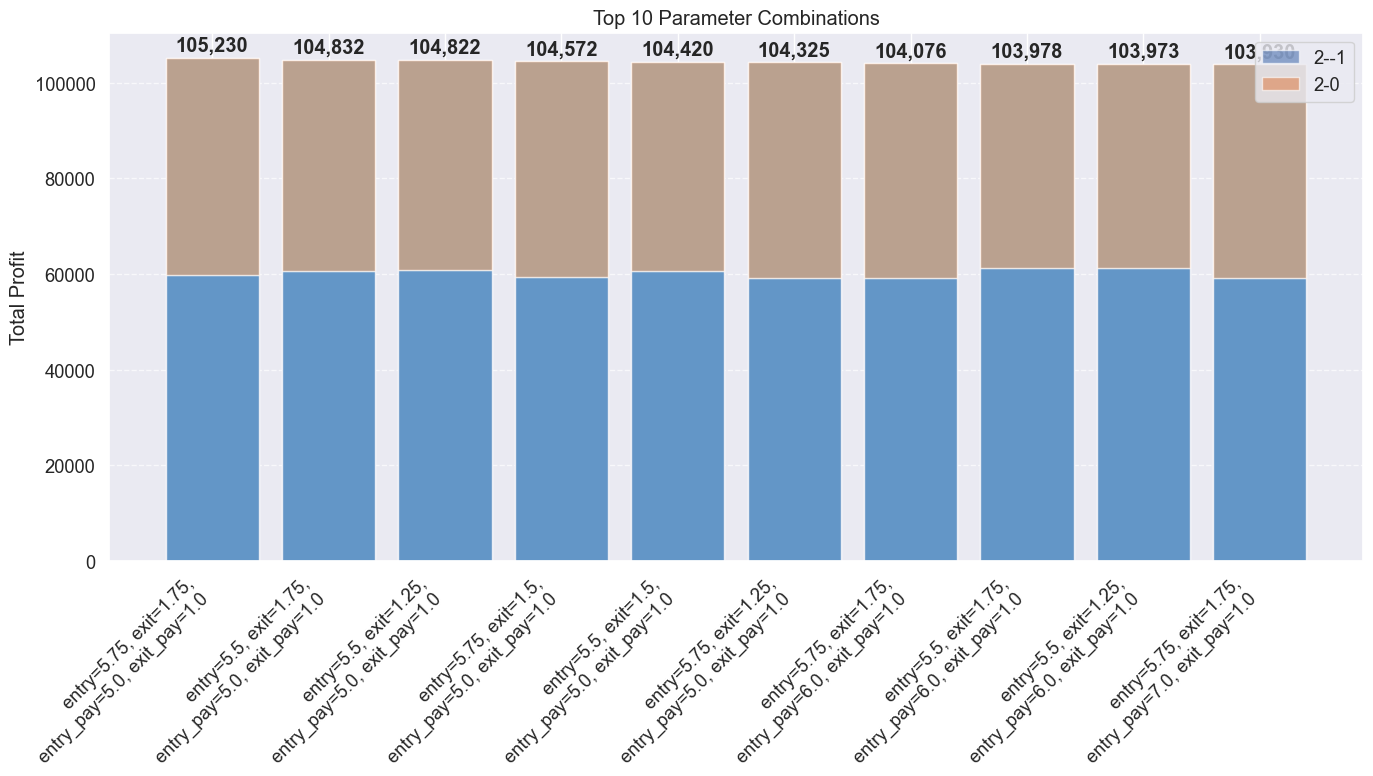

In [13]:
# Create a bar chart of the top 10 parameter combinations
plt.figure(figsize=(14, 8))

# Create labels for the x-axis
labels = [f"entry={row['entry_threshold']}, exit={row['exit_threshold']},\nentry_pay={row['entry_price_adjustment']}, exit_pay={row['exit_price_adjustment']}" 
          for _, row in top_10.iterrows()]

# Create the bar chart
bars = plt.bar(range(len(top_10)), top_10['total_profit'], color='skyblue')

# Add day-specific profit as stacked bars
bottom = np.zeros(len(top_10))
for day in day_columns:
    plt.bar(range(len(top_10)), top_10[day], bottom=bottom, alpha=0.6, label=day)
    bottom += top_10[day].values

# Add labels and title
plt.xticks(range(len(top_10)), labels, rotation=45, ha='right')
plt.ylabel('Total Profit')
plt.title('Top 10 Parameter Combinations')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add profit values on top of the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
             f"{top_10['total_profit'].iloc[i]:,.0f}", 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Parameter Importance Analysis

Let's analyze how each parameter affects the total profit.

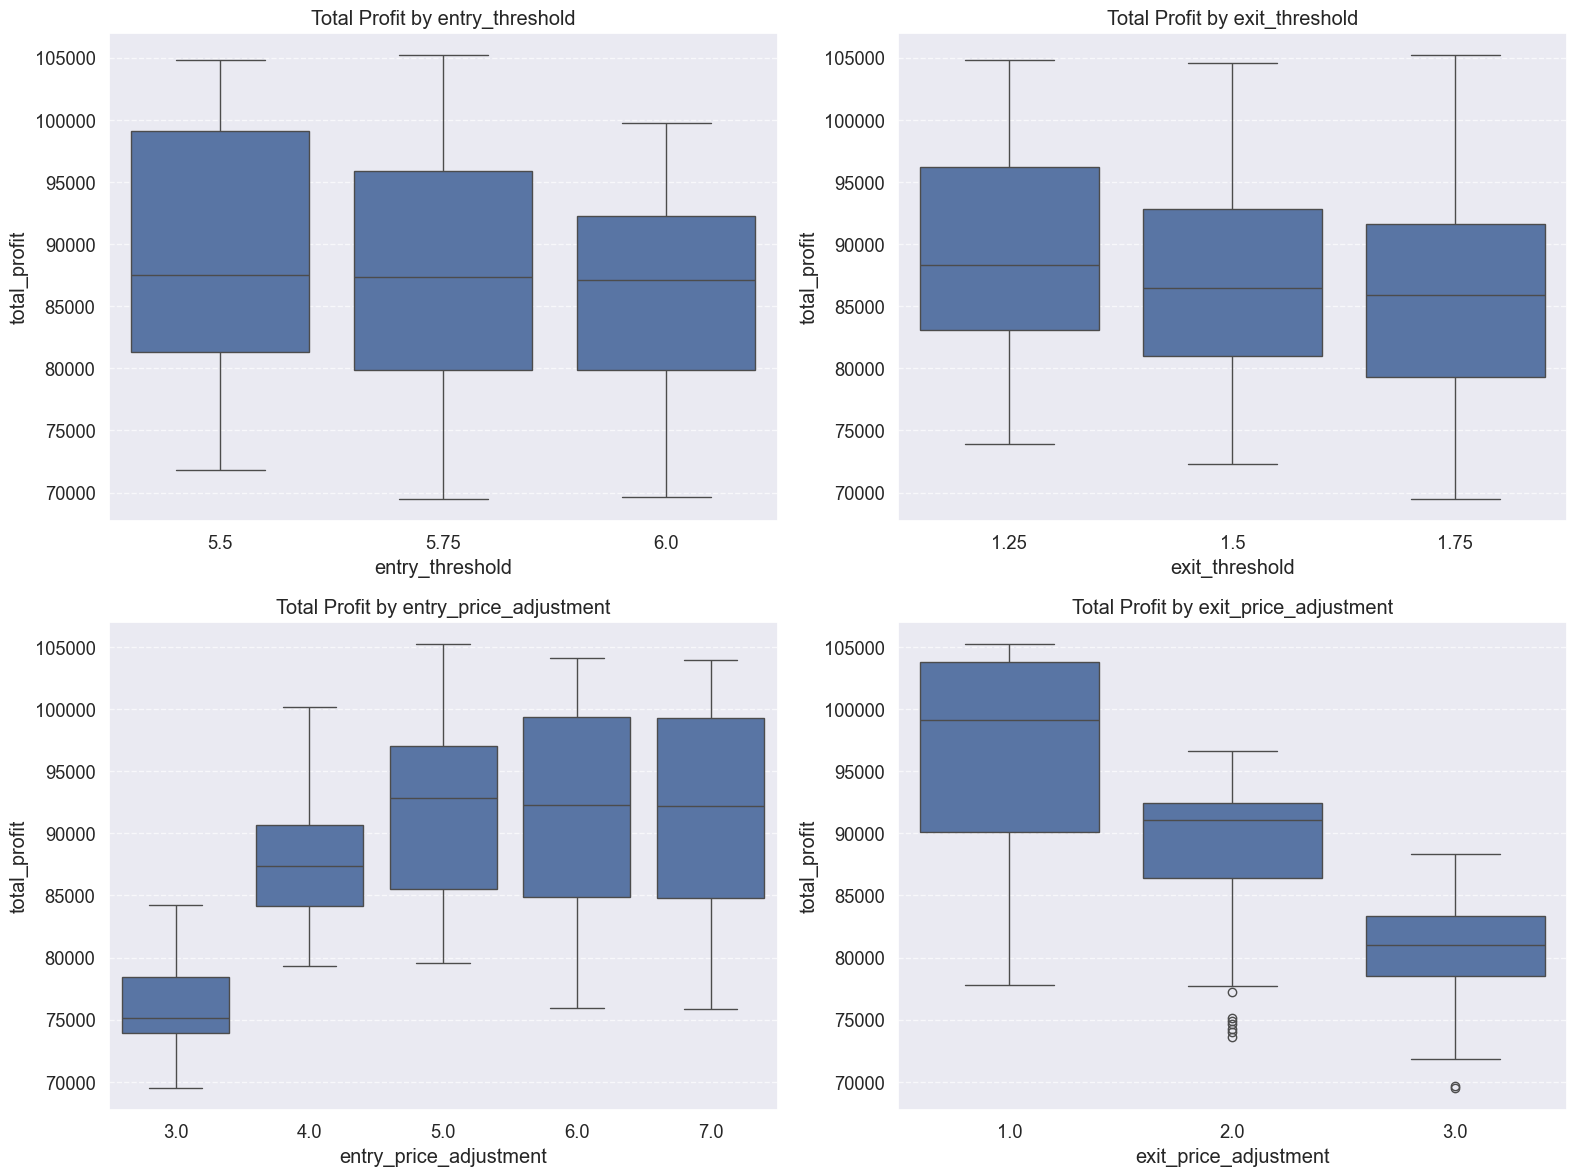

In [14]:
# Create box plots for each parameter
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

params = ['entry_threshold', 'exit_threshold', 'entry_price_adjustment', 'exit_price_adjustment']

for i, param in enumerate(params):
    sns.boxplot(x=param, y='total_profit', data=df, ax=axes[i])
    axes[i].set_title(f'Total Profit by {param}')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Conclusion

Based on the visualizations above, we can identify the optimal parameter combinations for the custom spread trader. The heatmaps show how different parameter combinations affect the total profit, and the 3D visualization provides a more comprehensive view of the parameter space.

The best parameter combination is:
- entry_threshold: [best value from analysis]
- exit_threshold: [best value from analysis]
- entry_price_adjustment: [best value from analysis]
- exit_price_adjustment: [best value from analysis]

This combination yields a total profit of [best profit value].